## Part 3: Data Preparation for Training

This notebook is used to examine the acquired raster files from Sentinel-2 Collection, handling the pixel values by removing NaN and normalizing each band to the range [0, 1].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from scipy import ndimage

In [45]:
### ==============================================================================================
### Read raster files
### ==============================================================================================
folder = "../data_example"
in_file = f'{folder}/KENNETH_20250109_post_fire.tif'
out_file = f'{folder}/KENNETH_20250109_interpolated.tif'
mask_file = f'{folder}/KENNETH_20250109_mask.tif'

In [46]:
with rio.open(in_file) as img:
    data = img.read().astype(np.float32)
    profile = img.profile
    data[data == img.nodata] = np.nan

In [47]:
### ==============================================================================================
### Fill NaN with the nearst values
### ==============================================================================================
filled_data = np.zeros_like(data)

for idx in range(data.shape[0]):
    band = data[idx,:, :].copy()
    mask = np.isnan(band)  # True is nan
    if np.any(mask):
        # Replace nan with nearest non-nan values
        indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        band = band[tuple(indices)]
    filled_data[idx] = band 

profile.update(dtype=rio.float32, nodata=np.nan)

In [48]:
with rio.open(out_file, 'w', **profile) as out:
    out.write(filled_data)

Band normalization is performed by following the guidance from the [document](https://github.com/allenai/satlas/blob/main/Normalization.md).
* TCI (RGB channels, divide by 255)
* B05, B06, B07, B08, B11, B12 (divide by 8160, clip to 0-1)*

In [49]:
### ==============================================================================================
### Normalize values for each band 
### ==============================================================================================
with rio.open(out_file) as f:
    bands = f.read()
    norm_data = np.zeros_like(bands)
    for i in range(bands.shape[0]):
        print(f"Max in origin band {i}: {np.max(bands[i])}, Min in origin band {i}: {np.min(bands[i])}")
        if i < 3:
            # Normalization for RGB -- divided by 255
            norm_data[i] = (bands[i] / 255).clip(0, 1)
        else:
            norm_data[i] = (bands[i] / 8160).clip(0, 1)
        print(f"Max in normalized band {i}: {np.max(norm_data[i])}, Min in normalized band {i}: {np.min(norm_data[i])}")


Max in origin band 0: 255.0, Min in origin band 0: 8.5
Max in normalized band 0: 1.0, Min in normalized band 0: 0.03333333507180214
Max in origin band 1: 255.0, Min in origin band 1: 7.5
Max in normalized band 1: 1.0, Min in normalized band 1: 0.029411764815449715
Max in origin band 2: 255.0, Min in origin band 2: 5.0
Max in normalized band 2: 1.0, Min in normalized band 2: 0.019607843831181526
Max in origin band 3: 6306.0, Min in origin band 3: 548.5
Max in normalized band 3: 0.7727941274642944, Min in normalized band 3: 0.06721813976764679
Max in origin band 4: 4963.0, Min in origin band 4: 501.0
Max in normalized band 4: 0.6082108020782471, Min in normalized band 4: 0.06139705702662468


In [50]:
with rio.open(mask_file) as m:
    mask = m.read()
mask.squeeze().shape

(225, 225)

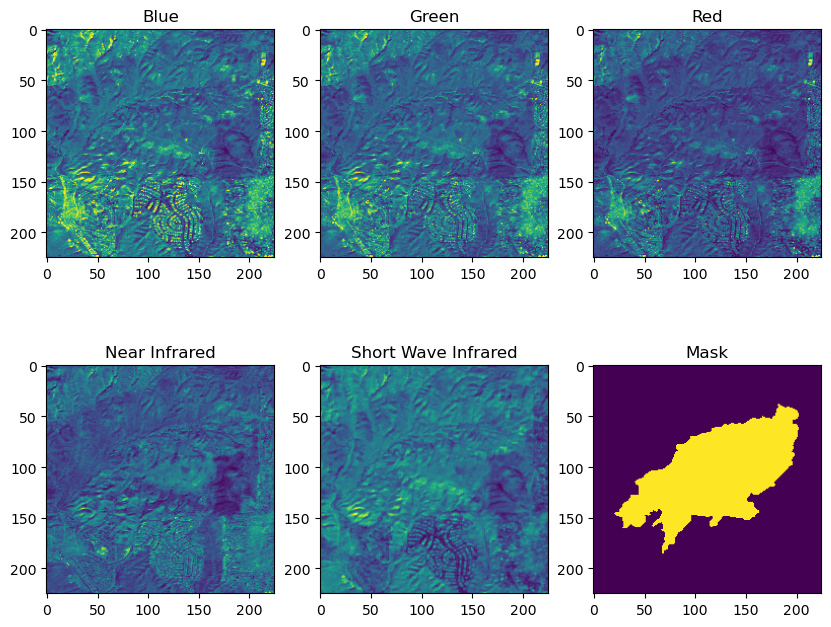

In [ ]:
### ==============================================================================================
### Visualizion
### ==============================================================================================
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax[0, 0].imshow(bands[0])
ax[0, 0].set_title("Blue")
ax[0, 1].imshow(bands[1])
ax[0, 1].set_title("Green")
ax[0, 2].imshow(bands[2])
ax[0, 2].set_title("Red")
ax[1, 0].imshow(bands[3])
ax[1, 0].set_title("Near Infrared")
ax[1, 1].imshow(bands[4])
ax[1, 1].set_title("Short Wave Infrared")
ax[1, 2].imshow(mask[0])
ax[1, 2].set_title("Mask")    # 0 is the background
plt.show()